# Table of Contents

* [Introduction](#Introduction)

* [Requirements](#Requirements)
    
* [Input_data](#Input_data)

* [Training_prediction](#Training_prediction)

* [Results](#Results)

* [Update](#Update)

# Introduction

This notebook presents an example of how to use [`rhced`](https://github.com/ecosang/rhced) module to disaggregate heating and cooling electricity consumption from the net electricity consumption. Based on the sample data obtained from a smart thermostat and power meter, we will give a realistic example of the use of this model for users.

# Requirements

There are several packages that needs to be installed. Please see [this page](https://github.com/ecosang/rhced#readme) for the required packages. In addition, change the directory and add path to use the modules.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import re
import sqlite3
import pathlib
import feather
import sys

%matplotlib inline

Change working directory and insert path.

In [2]:
init_wd=os.getcwd() #get current working directory
print(f'Current working directory is {init_wd}.') # The default is ~/rhced/notebook
# Add ~/rhced directory to the system path so that the module `rhced` can be loaded.
path=pathlib.Path(init_wd).parents[0].__str__()  
if not path in sys.path: 
    sys.path.insert(1, path)
os.chdir(path)
print(f'directory {path} is added to system path.')

Current working directory is c:\Users\ham9\rhced\notebook.
directory c:\Users\ham9\rhced is added to system path.


Loading modules. Warnings related to theano can be nelgected. If there are errors to import modules, please create a separate environment by using [`conda`](https://docs.conda.io/en/latest/) or `virtualenv` and install [`pymc3 > 3.11`](https://github.com/pymc-devs/pymc3) again.

In [3]:
from rhced.data_utils import * # for data pre-processing
from rhced.training import *   # training modules
from rhced.prediction import * # prediction modules

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Input_data

Input data consists of three parts: (1) meta data, (2) thermostat data, and (3) meter data.

## (1) Meta data

Each housing unit is classified two hierarchy: `bldg` and `unitcode`. `bldg` indicates the unique identifier of the building or site. `unitcode` is the unique identifier of the housing unit in a certain `bldg`. You need to specify the `start_date` and `end_date` to get access to the specific data. `bldg`, `unitcode`, `start_date`, and `end_date` are used for a unique identifier of (2) thermostat data and (3) meter data. So, please follow the same format given below.

In addition, `max_values` shows the maximum value of *net*, *heatpump heating*, *heatpump heating with defrost control*, *heatpump_cooling*, and *auxiliary heating* in Watt. During the calculation, the results are strictly restricted by the these maximum numbers, so please put numbers with a certain amount of margin. 120-150% can be a good choice.

`output_path` is used for storing outputs. Also, time interval is the model's time interval. We use 15-min interval due to defrost control. See section 2.2 in the paper.

In [4]:
bldg="sample_bldg" # building identifier. Use location identifier for single family detached house.
unitcode="sample" # housing unit identifier. 

start_date="2016-01-19"
end_date="2016-01-25"

max_values={'net_max':10000,'heat_max':2000,'cool_max':2000,'aux_max':6000,'df_max':4000} # unit of [Watt]

# define output_path. In this directory, we will create output_path/bldg/unitcode/ and store the outputs.
output_path=pathlib.Path().joinpath("outputs",bldg,unitcode)
time_interval=15 # due to defrost control, we use 15-min interval data (see Section 2.2 in the paper)

## (2) Thermostat data

Once you put all meta data information, what you need to do is just put the data for training in the specified data directory.   

Then, `unit_prediction` function in the below read data from the directory.  
For example, in this example, the meta data is *bldg*:`sample_bldg`, *unitcode*:`sample`, *start_date*:`2016-01-19`, *end_date*: `2016-01-25`.
In this case, the thermostat_data's directory is *~/rhced/data/sample_bldg/sample/raw_data/thermostat_data_sample_2016-01-19_2016-01-25.csv*.
The meter_data's directory is *~/rhced/data/sample_bldg/sample/raw_data/meter_data_sample_2016-01-19_2016-01-25.csv*.

To example data format, we import *thermostat_data* and *meter_data*.

In [5]:
# import thermostat_data and meter_data
thermostat_data_path=pathlib.Path().joinpath("data",bldg,unitcode,"raw_data","thermostat_data_sample_2016-01-19_2016-01-25.csv")
meter_data_path=pathlib.Path().joinpath("data",bldg,unitcode,"raw_data","meter_data_sample_2016-01-19_2016-01-25.csv")

df_thermostat=pd.read_csv(thermostat_data_path.__str__())
df_meter=pd.read_csv(meter_data_path.__str__())


*thermostat_data* has 7 columns.

|Column     |Unit|Type|Description|
|-----------|----|----|-----------|
|`timestamp`|    |str|Timestamp of the data point. The format should be `%Y-%m-%d %H:%M:%S` (e.g., 2016-01-02 13:15:00)|
|`unitcode` |    |str|Housing unit identifier. Any character is fine.|
|`operation`|    |str|Operation of HC system. See Section 3.3 in the paper.|
|`T_in`     |&deg;C|numeric|Indoor air temperature|
|`rh_in`    | - |numeric|Indoor air relative humidity in 0-1 scale.|
|`T_out`    |&deg;C|numeric|Outdoor air temperature|
|`rh_out`   |- |   numeric|Outdoor air relative humidity in 0-1 scale. 

In [6]:
df_thermostat.head(3)

,timestamp,unitcode,operation,T_in,rh_in,T_out,rh_out
0,2016-01-19 00:00:00,sample,idle,21.111111,0.34,0.527778,0.90
1,2016-01-19 00:05:00,sample,idle,21.111111,0.34,0.444444,0.91
2,2016-01-19 00:10:00,sample,idle,21.111111,0.34,0.388889,0.91


*meter_data* require 3 columns (`timestamp`, `unitcode`, and `net`). But, for the validation purpose, you can have HC data, too.

|Column     |Unit|Type|Description|
|-----------|----|----|-----------|
|`timestamp`|    |str|Timestamp of the data point. The format should be `%Y-%m-%d %H:%M:%S` (e.g., 2016-01-02 13:15:00)|
|`unitcode` |    |str|Housing unit identifier. Any character is fine.|
|`net`|W|numeric|Average power of net electricity during sampling interval in Watt.|
|`ahu`|W|numeric|Average power of air handler electricity during sampling interval in Watt (only necessary for validation purpose).|
|`heatpump`|W|numeric|Average power of heat pump electricity during sampling interval in Watt (only necessary for validation purpose).|
|`hvac`|W|numeric|Average power of air HC system (i.e., `ahu`+`heatpump`) during sampling interval in Watt (only necessary for validation purpose).|

In [7]:
df_meter.head(3)

,timestamp,unitcode,ahu,heatpump,hvac,net
0,2016-01-19 00:00:00,sample,4.210000,34.070000,38.280000,50.843333
1,2016-01-19 00:05:00,sample,4.180000,34.093333,38.273333,50.973333
2,2016-01-19 00:10:00,sample,4.203333,34.426667,38.630000,51.023333


# Training_prediction

The disaggregation model is unsupervised learning, so it is not necessarily to distinguish training/prediction. However, once the model is trained, it is not necessary to train or update model when there is new data. We just want to know the result. Therefore, training indicates the process of model update with new data, and prediction is the process of disaggregation with data and trained model parameters. 

Both training and prediction are done by using `unit_prediction` function. The function gets all the meta data information (`unitcode`, `bldg`, `start_date`, `end_date`, `max_values`,  `output_path`, and `time_interval`). 

Other function arguments control the model update. 

- `new_traiing`: Whether it is new training. If it is the first training of the specific housing unit, please put `True`. Otherwise, it should be `False`|
- `force_update`: When new data is available, the model check if the update is necessary. If new data doesn't include new HC operation, it is not updated. But, for the training purpose, you can force model update by putting `True` for this variable.|

The remaining arguments control model inference. `n_samples` is the number of samples to approximate the posterior distribution. `n_training` is the number of steps of ADVI learning. It should be large enough to guarantee the stochastic optimization of ADVI convergence. `n_inference` indicates the number of repeated ADVI. ADVI uses stochastic optimization, so the inference result may be local optima even if the convergence is observed with large `n_training`. To prevent this, you can repeat the inference with different initial values. This argument controls how many inference you want to repeat. 

In [6]:
df,outputs=unit_prediction(unitcode=unitcode,bldg=bldg,start_date=start_date,end_date=end_date,max_values=max_values,time_interval=time_interval,output_path=output_path,new_training=True,force_update=True,n_samples=10000,n_training=60000,n_inference=5)

C:\Users\ham9\anaconda3\envs\rhced\lib\site-packages\pandas\core\groupby\generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


Drop NA data to create training data.
scale const is {'T_out_max': 40.0, 'T_out_min': -20.0, 'T_out_upper': 1.0, 'T_out_lower': -1.0, 'T_in_max': 30.0, 'T_in_min': 10.0, 'T_in_upper': 1.0, 'T_in_lower': -1.0, 'wb_in_max': 30.0, 'wb_in_min': 0.0, 'wb_in_upper': 1.0, 'wb_in_lower': -1.0, 'net_max': 10000, 'net_min': 0.0, 'heat_max': 2000, 'cool_max': 2000, 'df_max': 4000, 'aux_max': 6000}.
New training, so new training and export the trained results.
New training


C:\Users\ham9\anaconda3\envs\rhced\lib\site-packages\theano\gpuarray\dnn.py:192: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn(
WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.


Finished [100%]: Average Loss = -967.32


New training


Finished [100%]: Average Loss = -966.71


New training


Finished [100%]: Average Loss = -966.09


New training


Finished [100%]: Average Loss = -953.14


New training


Finished [100%]: Average Loss = -967.81


During this training, heat1 hours: 29.25,             heat2 hours: 0.0,             df1 hours: 83.0,             df2 hours: 0.0,             cool1 hours: 0.0,             cool2 hours: 0.0,             aux1 hours: 4.75,             fan1 hours: 0.0
So far, heat1 hours: 29.25,             heat2 hours: 0.0,             df1 hours: 83.0,             df2 hours: 0.0,             cool1 hours: 0.0,             cool2 hours: 0.0,             aux1 hours: 4.75,             fan1 hours: 0.0
feather file is created at outputs\sample_bldg\sample\df_2016-01-19_2016-01-25.feather
lower: 62.211211695933976
median: 135.9019795220793
upper: 215.75736472097094
measurement: 126.32639104166667


In [9]:
# #load data without training.
# df_values_path=output_path.joinpath("df_2016-01-19_2016-01-25.feather")
# df=feather.read_dataframe(df_values_path.__str__())

# Results

The results of `unit_prediction` function are given in two formats. `outputs` is a dictionary that gives all the posterior distribution of parameter and variables. `df` is a summary of `outputs` in a Pandas dataframe format. `df` gives all the HC signals and 2.5 (lower), 50 (mid), and 97.5 (upper) percentiles of the posterior distribution of each operation's power. 

Since `P_{HC_operation}` is given in power (Watt), the median of predicted HC kWh value of the data period can be calculated by  `np.nanmean(df['P_hc_mid'])/1000*24*n_days`. The mean of `P_hc_mid` is divided by 1000 to make kW, and then it is multiplied the number of hours during the data period to calculate kWh.


In [10]:
df.head(3)

,timestamp,i_hc,i_heat1_all,i_cool1,i_aux1,i_df1,i_heat1,i_fan1,P_hc_lower,P_hc_mid,...,P_aux1_mid,P_aux1_upper,P_aux1_uq,P_aux1_lq,P_fan1_lower,P_fan1_mid,P_fan1_upper,P_fan1_uq,P_fan1_lq,hc
0,2016-01-19 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.394444
1,2016-01-19 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.722222
2,2016-01-19 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.444444


In addition, you can visualize timeseries prediction results.

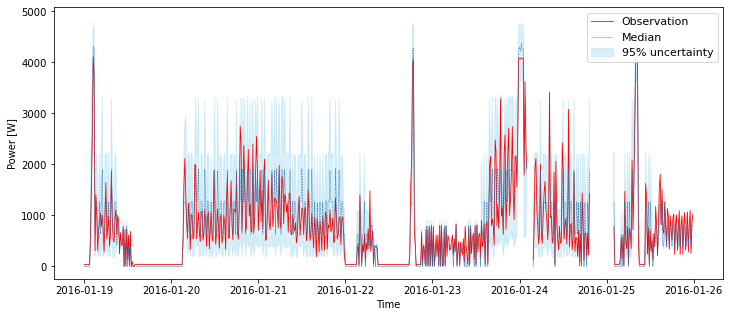

In [11]:
# 
x_time=pd.to_datetime(df['timestamp'])
fig, ax = plt.subplots(nrows=1, ncols=1,  figsize=(12,5))
ax.plot(x_time,df['hc'],'-',linewidth=0.8,color="red",label="Observation")
ax.fill_between(x=x_time,y1=df['P_hc_lower'],y2=df['P_hc_upper'],alpha=0.3,color="skyblue",label="95% uncertainty")
ax.plot(x_time,df['P_hc_mid'],'--',linewidth=0.5,label='Median')
ax.set(ylabel="Power [W]",xlabel="Time")
ax.legend(fontsize=11,loc='upper right')


# Update

As shown in Figure 11 in the paper, the model automatically updates model parameters when new HC operation is observed. In the below code, the model predicts for the several weeks of data and updates whenever necessary. The results are not explicitly visualized in this notebook, but the purpose of below code is to give how to do it.

In [10]:
start_date_="2016-01-26"
end_date_="2016-02-01"

start_date_vector=pd.date_range(start_date_, periods=24, freq='7D')
end_date_vector=pd.date_range(end_date_, periods=24, freq='7D')

for i_start,i_end in zip(start_date_vector,end_date_vector):
    start_date=i_start.strftime("%Y-%m-%d")
    end_date=i_end.strftime("%Y-%m-%d")
    df,outputs=unit_prediction(unitcode=unitcode,bldg=bldg,start_date=start_date,end_date=end_date,output_path=output_path,new_training=False,force_update=False,time_interval=time_interval,n_samples=10000,n_training=60000,n_inference=3)


last_prior_values_path is outputs\sample_bldg\sample\prior_values_2016-01-19_2016-01-25.pickle
last_input_values_path is outputs\sample_bldg\sample\input_values_2016-01-19_2016-01-25.pickle
Model time_interval from previous training output is 15.0 minutes. If not please double check.
Drop NA data to create training data.
scale const is {'T_out_max': 40.0, 'T_out_min': -20.0, 'T_out_upper': 1.0, 'T_out_lower': -1.0, 'T_in_max': 30.0, 'T_in_min': 10.0, 'T_in_upper': 1.0, 'T_in_lower': -1.0, 'wb_in_max': 30.0, 'wb_in_min': 0.0, 'wb_in_upper': 1.0, 'wb_in_lower': -1.0, 'net_max': 10000, 'net_min': 0.0, 'heat_max': 2000, 'cool_max': 2000, 'df_max': 4000, 'aux_max': 6000}.
Posterior prediction only
feather file is created at outputs\sample_bldg\sample\df_2016-01-26_2016-02-01.feather
lower: 75.09484494702993
median: 158.78119703568052
upper: 248.47319884467595
measurement: 153.6213508333333
last_prior_values_path is outputs\sample_bldg\sample\prior_values_2016-01-19_2016-01-25.pickle
last_in

Finished [100%]: Average Loss = -1,381.7


Finished [100%]: Average Loss = -1,383.2


Finished [100%]: Average Loss = -1,381.2


During this training, heat1 hours: 4.25,             heat2 hours: 0.0,             df1 hours: 4.5,             df2 hours: 0.0,             cool1 hours: 11.25,             cool2 hours: 0.0,             aux1 hours: 0.0,             fan1 hours: 0.0
So far, heat1 hours: 33.5,             heat2 hours: 0.0,             df1 hours: 87.5,             df2 hours: 0.0,             cool1 hours: 11.25,             cool2 hours: 0.0,             aux1 hours: 4.75,             fan1 hours: 0.0


c:\Users\ham9\rhced\rhced\training.py:10: RuntimeWarning: overflow encountered in exp
  return 1./(1+np.exp(-500*(-x+x0)))


feather file is created at outputs\sample_bldg\sample\df_2016-03-29_2016-04-04.feather
lower: 11.835328740757936
median: 15.77275023417187
upper: 24.362932546392383
measurement: 16.26179611111111
last_prior_values_path is outputs\sample_bldg\sample\prior_values_2016-03-29_2016-04-04.pickle
last_input_values_path is outputs\sample_bldg\sample\input_values_2016-03-29_2016-04-04.pickle
Model time_interval from previous training output is 15.0 minutes. If not please double check.
Drop NA data to create training data.
scale const is {'T_out_max': 40.0, 'T_out_min': -20.0, 'T_out_upper': 1.0, 'T_out_lower': -1.0, 'T_in_max': 30.0, 'T_in_min': 10.0, 'T_in_upper': 1.0, 'T_in_lower': -1.0, 'wb_in_max': 30.0, 'wb_in_min': 0.0, 'wb_in_upper': 1.0, 'wb_in_lower': -1.0, 'net_max': 10000, 'net_min': 0.0, 'heat_max': 2000, 'cool_max': 2000, 'df_max': 4000, 'aux_max': 6000}.
Posterior prediction only
feather file is created at outputs\sample_bldg\sample\df_2016-04-05_2016-04-11.feather
lower: 3.879602

c:\Users\ham9\rhced\rhced\training.py:10: RuntimeWarning: overflow encountered in exp
  return 1./(1+np.exp(-500*(-x+x0)))


Posterior prediction only
feather file is created at outputs\sample_bldg\sample\df_2016-04-26_2016-05-02.feather
lower: 50.436950779926505
median: 62.16469022761572
upper: 72.66923581958643
measurement: 60.60450805555556
last_prior_values_path is outputs\sample_bldg\sample\prior_values_2016-03-29_2016-04-04.pickle
last_input_values_path is outputs\sample_bldg\sample\input_values_2016-03-29_2016-04-04.pickle
Model time_interval from previous training output is 15.0 minutes. If not please double check.
Drop NA data to create training data.
scale const is {'T_out_max': 40.0, 'T_out_min': -20.0, 'T_out_upper': 1.0, 'T_out_lower': -1.0, 'T_in_max': 30.0, 'T_in_min': 10.0, 'T_in_upper': 1.0, 'T_in_lower': -1.0, 'wb_in_max': 30.0, 'wb_in_min': 0.0, 'wb_in_upper': 1.0, 'wb_in_lower': -1.0, 'net_max': 10000, 'net_min': 0.0, 'heat_max': 2000, 'cool_max': 2000, 'df_max': 4000, 'aux_max': 6000}.
Posterior prediction only
feather file is created at outputs\sample_bldg\sample\df_2016-05-03_2016-05-0